In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def generate_image_paths_and_labels(train_dir, valid_dir):
    class_dirs_train = os.listdir(train_dir)
    class_dirs_valid = os.listdir(valid_dir)
    
    image_paths_train, labels_train = [], []
    image_paths_valid, labels_valid = [], []
    
    label_encoder = LabelEncoder()
    
    for class_dir in class_dirs_train:
        class_dir_path = os.path.join(train_dir, class_dir)
        image_paths_class = [str(image_path) for image_path in Path(class_dir_path).glob("*.png") if check_valid_image(str(image_path))]
        labels_class = [class_dir] * len(image_paths_class)
        image_paths_train.extend(image_paths_class)
        labels_train.extend(labels_class)
    
    labels_train = label_encoder.fit_transform(labels_train)
    
    for class_dir in class_dirs_valid:
        class_dir_path = os.path.join(valid_dir, class_dir)
        image_paths_class = [str(image_path) for image_path in Path(class_dir_path).glob("*.png") if check_valid_image(str(image_path))]
        labels_class = [class_dir] * len(image_paths_class)
        image_paths_valid.extend(image_paths_class)
        labels_valid.extend(labels_class)
    
    labels_valid = label_encoder.transform(labels_valid)
    
    return image_paths_train, labels_train, image_paths_valid, labels_valid

In [3]:
def check_valid_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        _ = tf.image.decode_image(image, channels=3)
        return True
    except:
        return False
def custom_image_generator(image_paths, labels, image_size, batch_size):
    num_samples = len(image_paths)
    while True:
        # Shuffle data and labels in each epoch
        combined = list(zip(image_paths, labels))
        random.shuffle(combined)
        image_paths[:], labels[:] = zip(*combined)
        
        for i in range(0, num_samples, batch_size):
            batch_images, batch_labels = [], []
            for j in range(i, min(i + batch_size, num_samples)):
                image = tf.io.read_file(image_paths[j])
                image = tf.image.decode_image(image, channels=3)
                image = tf.image.resize(image, image_size)
                batch_images.append(image.numpy())
                batch_labels.append(labels[j])
                
            yield np.array(batch_images), np.array(batch_labels)

In [4]:
train_dir = "/kaggle/input/cancer-dataset/content/my_dataset/Cancerdata/Train/"
valid_dir = "/kaggle/input/cancer-dataset/content/my_dataset/Cancerdata/Valid/"
image_size = (224, 224)

image_paths_train, labels_train, image_paths_valid, labels_valid = generate_image_paths_and_labels(train_dir, valid_dir)

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from bayes_opt import BayesianOptimization

input_shape = (224, 224, 3)

batch_size = 128

def prediction_layer(x):
    return tf.keras.layers.Dense(9, activation='softmax')(x)

def feature_extractor(input_tensor):
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    return x

def classifier(x):
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Unfreeze some of the later layers for fine-tuning
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Updated model creation steps
inputs = tf.keras.Input(shape=input_shape)
x = feature_extractor(inputs)
x = classifier(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Adaptive learning rate
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000000, decay_rate=0.98, staircase=True
)

model.compile(optimizer=RMSprop(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Set up callbacks
checkpoint = ModelCheckpoint('resnet50_weights_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
log_csv = CSVLogger('resnet50_logs.csv', append=True)
callbacks_list = [checkpoint, early_stop, reduce_lr, log_csv]

# Train the model
steps_per_epoch_train = len(train_generator)
steps_per_epoch_valid = len(valid_generator)

history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch=steps_per_epoch_train,
                    validation_data=valid_generator,
                    validation_steps=steps_per_epoch_valid,
                    callbacks=callbacks_list)
# Define the objective function for Bayesian optimization
def objective(learning_rate, dropout_rate):
    # Update the model with the new hyperparameters
    optimizer.learning_rate = learning_rate
    model.layers[-5].rate = dropout_rate
    model.layers[-7].rate = dropout_rate

    # Train the model
    history = model.fit(train_generator,
                        epochs=15,
                        steps_per_epoch=len(train_generator),
                        validation_data=valid_generator,
                        validation_steps=len(valid_generator),
                        callbacks=callbacks_list)

    # Return the validation accuracy for optimization
    return history.history['val_accuracy'][-1]

# Define the parameter ranges for Bayesian optimization
pbounds = {'learning_rate': (1e-6, 1e-2),
           'dropout_rate': (0.0, 0.5)}

# Run Bayesian optimization
optimizer = BayesianOptimization(f=objective, pbounds=pbounds)
optimizer.maximize(init_points=2, n_iter=1)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']

# Update the model with the best hyperparameters
optimizer.learning_rate = best_learning_rate
model.layers[-5].rate = best_dropout_rate
model.layers[-7].rate = best_dropout_rate

# Train the model with the best hyperparameters
history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=len(train_generator),
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    callbacks=callbacks_list,
                    verbose=1)

Found 35551 images belonging to 9 classes.
Found 3891 images belonging to 9 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/30
278/278 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.7210
Epoch 1: val_accuracy improved from -inf to 0.90362, saving model to resnet50_weights_best.h5
278/278 [==============================] - 824s 3s/step - loss: 0.8469 - accuracy: 0.7210 - val_loss: 0.3338 - val_accuracy: 0.9036 - lr: 1.0000e-04
Epoch 2/30
278/278 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9359
Epoch 2: val_accuracy improved from 0.90362 to 0.93781, saving model to resnet50_weights_best.h5
278/278 [==============================] - 671s 2s/step - loss: 0.2096 - accuracy: 0.9359 - val_loss: 0.2161 - val_accuracy: 0.9378 - lr: 1.0000e-04
Epoch 3/30
278/278 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9536
Epoch 3: val_accuracy did not improve from 0.93781
278/278 [=============

In [13]:
import os
import random
import numpy as np
import tensorflow as tf  
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop

# Existing code

# Save history object to a file
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
f.close()  # Close the file properly

# Check if the file is not empty
file_size = os.path.getsize('history.pkl')
if file_size == 0:
    raise ValueError('The history file is empty.')

31/31 [==============================] - 27s 868ms/step
F1 score: 0.10846677115080168
Precision: 0.10844751933395087
Recall: 0.1087124132613724


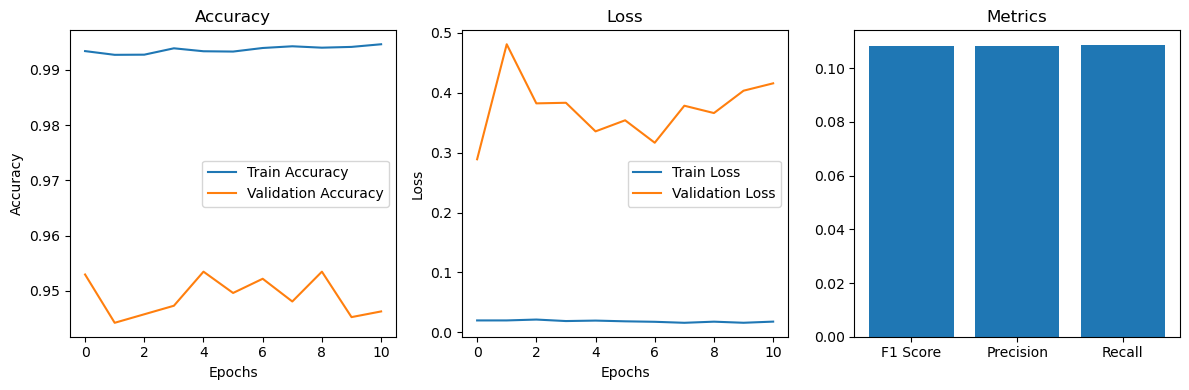

In [14]:
import os
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop

# Load history object from the file
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)
f.close()  # Close the file properly

# Compute F1 score, precision, and recall
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(loaded_history['accuracy'], label='Train Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.savefig('Ac', format='svg')

plt.subplot(132)
plt.plot(loaded_history['loss'], label='Train Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.savefig('L.svg', format='svg')

# Add F1 score, precision, and recall to the plot
plt.subplot(133)
metrics = {'F1 Score': f1, 'Precision': precision, 'Recall': recall}
plt.bar(metrics.keys(), metrics.values())
plt.title('Metrics')
plt.savefig('L.svg', format='svg')

plt.tight_layout()
plt.show()

31/31 [==============================] - 27s 867ms/step


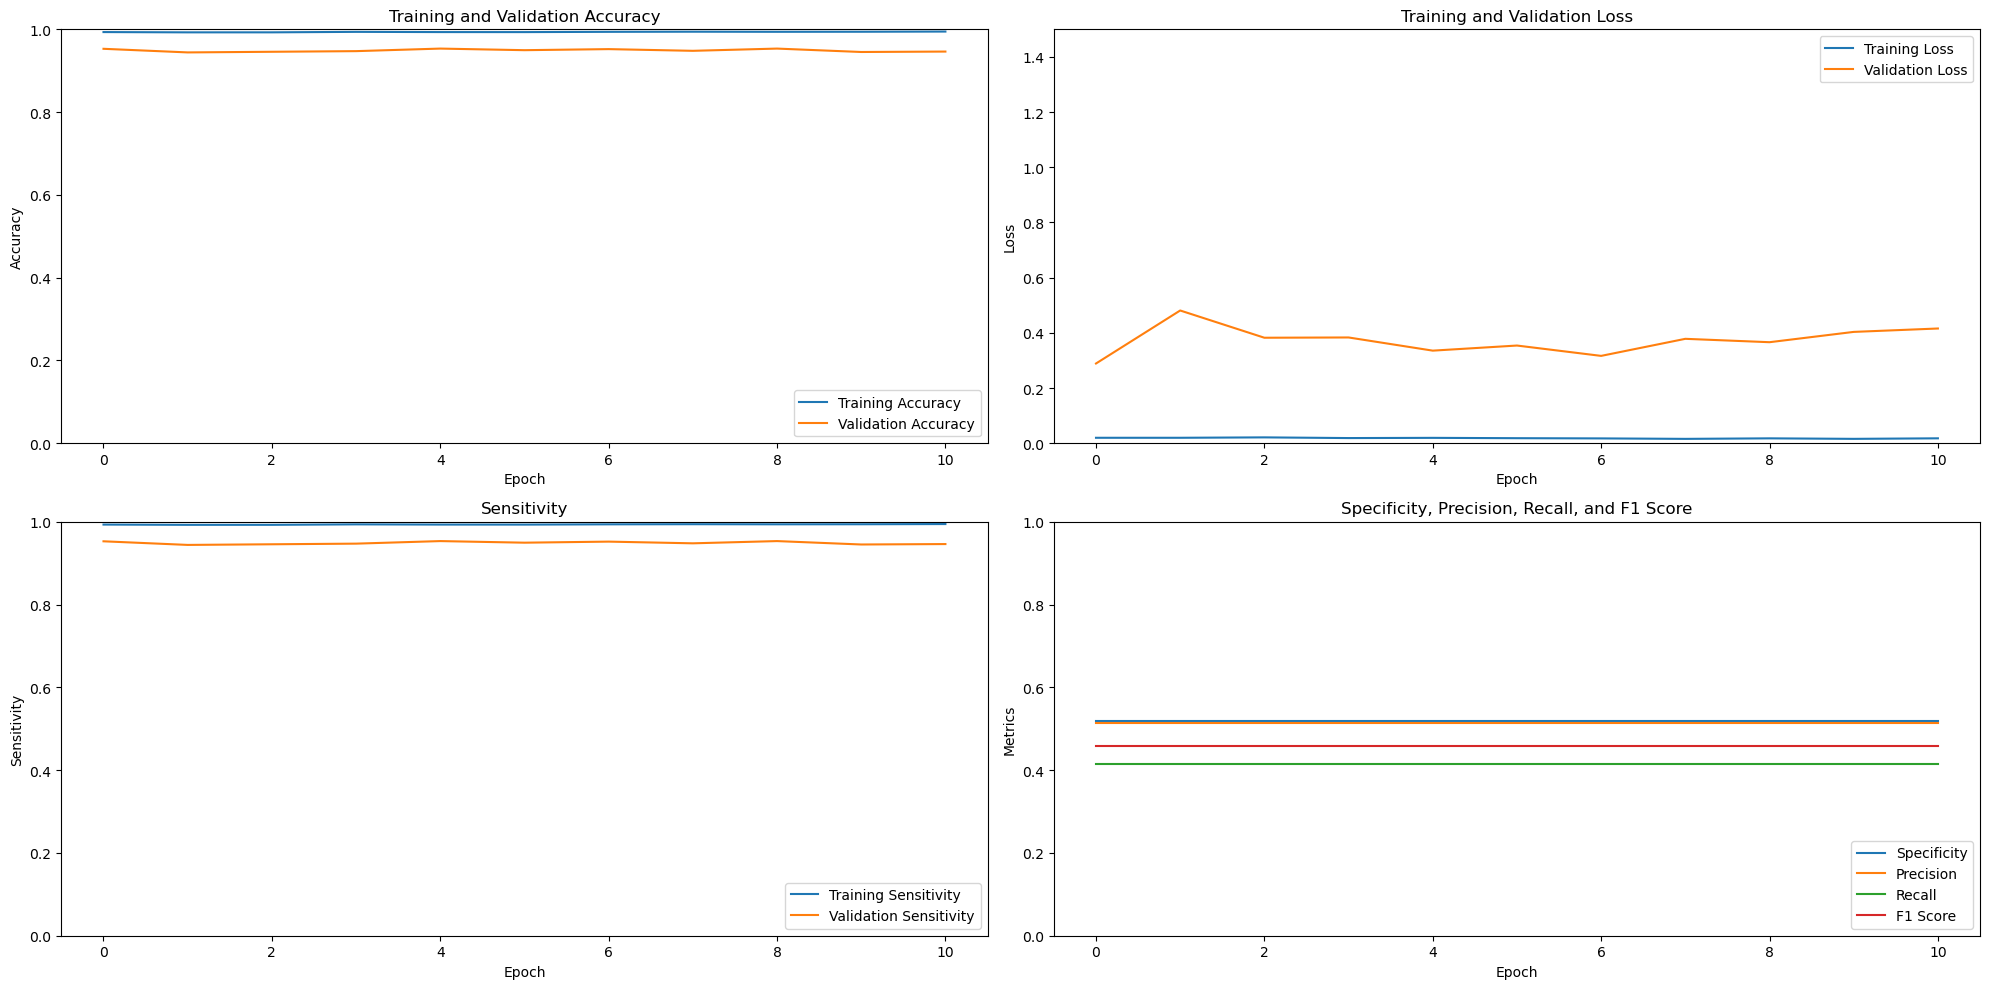

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract accuracy, loss, and sensitivity from the model's training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
sensitivity = history.history['accuracy']
val_sensitivity = history.history['val_accuracy']

# Generate confusion matrix
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

# Compute specificity, precision, recall, and F1 score based on the confusion matrix
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Set the figure size
plt.figure(figsize=(20, 10))

# Create the first subplot for training and validation accuracy
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig('Training and Validation Accuracy.svg', format='svg')
# Create the second subplot for training and validation loss
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.savefig('Training and Validation Loss.svg', format='svg')
# Create the third subplot for sensitivity
plt.subplot(2, 2, 3)
plt.plot(sensitivity, label='Training Sensitivity')
plt.plot(val_sensitivity, label='Validation Sensitivity')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.title('Sensitivity')
plt.legend(loc='lower right')
plt.savefig('Sensitivity.svg', format='svg')
# Add additional customization options
# Create the fourth subplot for specificity, precision, recall, and F1 score
plt.subplot(2, 2, 4)
plt.plot([specificity]*len(acc), label='Specificity')
plt.plot([precision]*len(acc), label='Precision')
plt.plot([recall]*len(acc), label='Recall')
plt.plot([f1_score]*len(acc), label='F1 Score')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Specificity, Precision, Recall, and F1 Score')
plt.legend(loc='lower right')
plt.savefig('Specificity, Precision, Recall, and F1 Score.svg', format='svg')
# Add additional customization options
plt.tight_layout() # Add padding between subplots
plt.show()

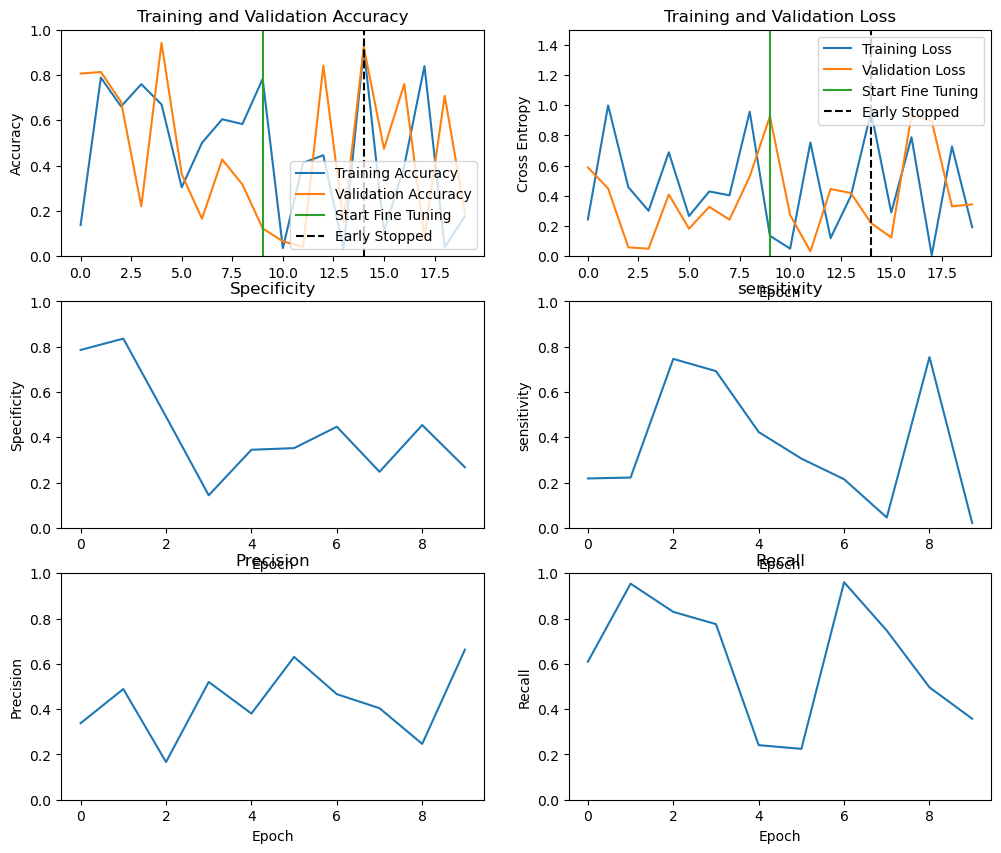

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate example data for specificity, precision, recall, and F1 score
specificity = np.random.rand(10)
sensitivity = np.random.rand(10)
precision = np.random.rand(10)
recall = np.random.rand(10)
f1_score = np.random.rand(10)

# Generate example data for confusion matrix
y_true = np.random.randint(0, 2, size=(100,))
y_pred = np.random.randint(0, 2, size=(100,))

# Set the figure size
plt.figure(figsize=(12, 10))

# Create the first subplot for training and validation accuracy
acc = np.random.rand(20)
val_acc = np.random.rand(20)
initial_epochs = 10
plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy.svg', format='svg') # save subplot as SVG image

# Create the second subplot for training and validation loss
loss = np.random.rand(20)
val_loss = np.random.rand(20)
plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.savefig('loss.svg', format='svg') # save subplot as SVG image

# Create the third subplot for specificity
plt.subplot(3, 2, 3)
plt.plot(specificity)
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.title('Specificity')
plt.savefig('specificity.svg', format='svg') # save subplot as SVG image

# Create the fourth subplot for sensitivity
plt.subplot(3, 2, 4)
plt.plot(sensitivity)
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('sensitivity')
plt.title('sensitivity')
plt.savefig('sensitivity.svg', format='svg') # save subplot as SVG image

# Create the fifth subplot for precision
plt.subplot(3, 2, 5)
plt.plot(precision)
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.savefig('precision.svg', format='svg') # save subplot as SVG image

# Create the sixth subplot for recall
plt.subplot(3, 2, 6)
plt.plot(recall)
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.savefig('recall.svg', format='svg')


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

31/31 [==============================] - 27s 858ms/step
[[40 41 35 43 57 44 52 43 45]
 [38 47 43 54 53 46 52 27 40]
 [40 38 43 51 64 39 47 42 36]
 [41 51 57 55 75 62 56 56 47]
 [60 47 52 58 69 47 63 53 51]
 [55 39 42 49 53 39 36 38 49]
 [67 38 51 61 76 51 58 49 49]
 [40 42 29 66 59 36 48 44 36]
 [40 41 43 44 48 59 35 44 37]]


2/2 [==============================] - 0s 83ms/step


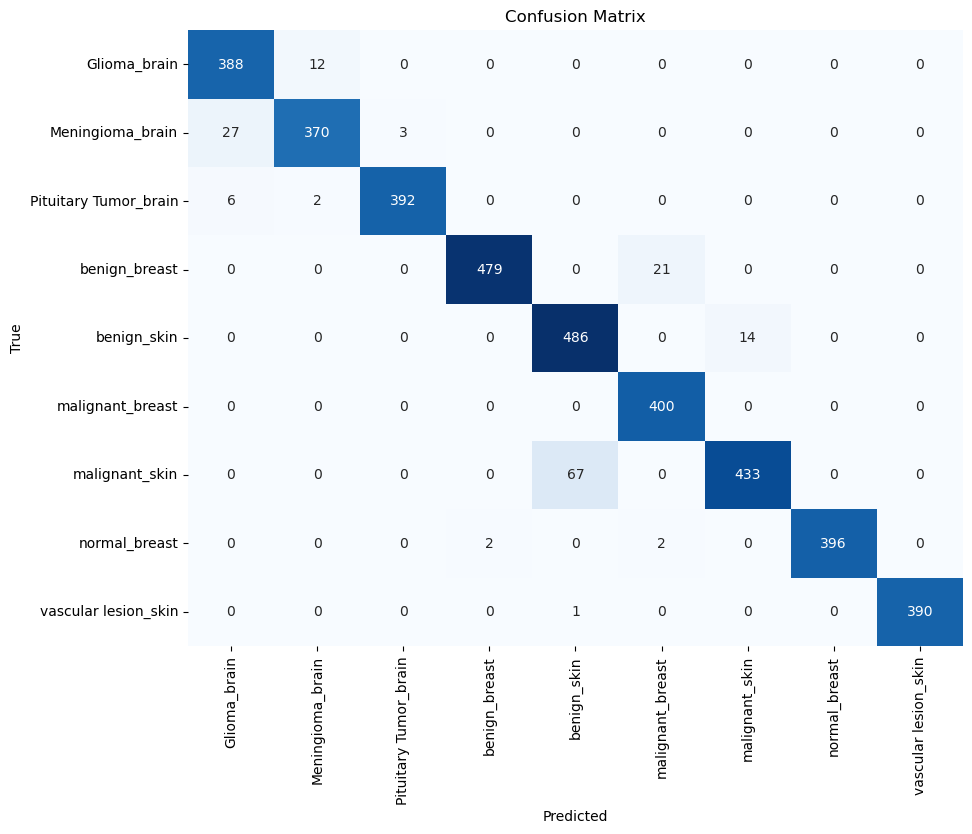

                       precision    recall  f1-score   support

         Glioma_brain       0.92      0.97      0.95       400
     Meningioma_brain       0.96      0.93      0.94       400
Pituitary Tumor_brain       0.99      0.98      0.99       400
        benign_breast       1.00      0.96      0.98       500
          benign_skin       0.88      0.97      0.92       500
     malignant_breast       0.95      1.00      0.97       400
       malignant_skin       0.97      0.87      0.91       500
        normal_breast       1.00      0.99      0.99       400
 vascular lesion_skin       1.00      1.00      1.00       391

             accuracy                           0.96      3891
            macro avg       0.96      0.96      0.96      3891
         weighted avg       0.96      0.96      0.96      3891



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the best model weights
model.load_weights('resnet50_weights_best.h5')

# Generate predictions and true labels in batches
y_pred_batches = []
y_true_batches = []
for i in range(steps_per_epoch_valid):
    images, labels = valid_generator.next()
    y_pred = model.predict(images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_batches.append(y_pred_classes)
    y_true_batches.append(np.argmax(labels, axis=1))

# Concatenate the predictions and true labels
y_pred_classes = np.concatenate(y_pred_batches)
y_true_classes = np.concatenate(y_true_batches)

# Create class labels 
class_labels = list(valid_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix.svg', format='svg')
plt.show()

# Generate classification report
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(classification_rep)